# Lab02 - Pedestrian Dead Reckoning

Course: Navigation Systems (WS2025, GST330UF)

Authors: Bernadette Kakuska & Hannah Öttl

Date: 15.12.2025

In [466]:
# libraries
import os
import numpy as np
import pandas as pd
import math as m
import time
import matplotlib.pyplot as plt
import scipy.signal as sp   # for filtering
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks



##### Data import

In [467]:
# file paths
base_path = os.getcwd()
path_data = os.path.join(base_path, "data_HeaderlineWithoutUnits")
path_results = os.path.join(base_path, "results")


In [468]:
# Accelerometer Data
acc_data = pd.read_csv(os.path.join(path_data, "accelerometer.csv"), 
                       sep=",", skiprows=0, header=0)
acc_data

# units: time [ms], acc_x [ms⁻²], acc_y [ms⁻²], acc_z [ms⁻²]

,time,acc_x,acc_y,acc_z
0,0,-0.633865,-0.364068,-9.592368
1,10,-0.694169,-0.310348,-9.781810
2,20,-0.593313,-0.249745,-9.932944
3,30,-0.291644,-0.190339,-10.057292
4,40,-0.154875,-0.116268,-10.148272
...,...,...,...,...
18395,183950,-0.242712,-0.318130,-9.744251
18396,183960,-0.076016,-0.602142,-9.628581
18397,183970,-0.279673,-0.477045,-9.786599
18398,183980,-0.373196,-0.316035,-9.733627


In [469]:
# Barometer Data
baro_data = pd.read_csv(os.path.join(path_data, "barometer.csv"), 
                       sep=",", skiprows=0, header=0)
baro_data

# units: time [ms], pressure [mBar]


,time,pressure
0,0,984.970474
1,1000,984.966888
2,2000,984.963379
3,3000,984.955673
4,4000,984.954987
...,...,...
179,179000,984.942398
180,180000,984.933929
181,181000,984.933929
182,182000,984.933929


In [470]:
# Ground-Truth Data
grtr_data = pd.read_csv(os.path.join(path_data, "groundTruth.csv"), 
                       sep=",", skiprows=0, header=0)
grtr_data

# units: time[ms], x[m], y[m], latitude[°], longitude[°]

,time,x,y,latitude,longitude
0,0.000,0.000000,0.000000,47.06422,15.45291
1,8.333,0.000110,-0.000026,47.06422,15.45291
2,16.667,0.000202,-0.000089,47.06422,15.45291
3,25.000,0.000288,-0.000185,47.06422,15.45291
4,33.333,0.000376,-0.000310,47.06422,15.45291
...,...,...,...,...,...
5889,182125.000,0.022305,0.008859,47.06422,15.45291
5890,182133.333,0.022111,0.008802,47.06422,15.45291
5891,182141.667,0.021872,0.008697,47.06422,15.45291
5892,182150.000,0.021594,0.008591,47.06422,15.45291


In [471]:
# Gyroscope Data
gyro_data = pd.read_csv(os.path.join(path_data, "gyroscope.csv"), 
                       sep=",", skiprows=0, header=0)
gyro_data

# units: time[ms], gyro_x[rad/s], gyro_y[rad/s], gyro_z[rad/s]

,time,gyro_x,gyro_y,gyro_z
0,0,-0.096788,0.118042,-0.047132
1,10,-0.090870,0.116402,-0.069423
2,20,-0.061148,0.089168,-0.058506
3,30,-0.011676,0.037025,-0.039837
4,40,0.040520,-0.019704,-0.040591
...,...,...,...,...
18395,183950,0.064119,-0.098101,-0.003915
18396,183960,0.050061,-0.076272,-0.018597
18397,183970,0.017183,-0.036650,-0.029343
18398,183980,-0.011957,0.015003,-0.025506


In [472]:
# Magnetometer Data
mag_data = pd.read_csv(os.path.join(path_data, "magnetometer.csv"), 
                       sep=",", skiprows=0, header=0)
mag_data

# units: time[ms], mag_x[μT], mag_y[μT], mag_z[μT]

,time,mag_x,mag_y,mag_z
0,0,-1.421341,19.678070,-41.277657
1,10,-1.378044,19.599060,-41.194695
2,20,-1.503525,19.547516,-41.245903
3,30,-1.499771,19.508377,-41.265495
4,40,-1.761223,19.461792,-41.377472
...,...,...,...,...
18395,183950,-3.798759,18.204559,-41.585686
18396,183960,-3.602898,18.325775,-41.829407
18397,183970,-3.716156,18.317139,-41.968430
18398,183980,-3.879196,18.473526,-42.033295


In [473]:
# Reference Orientation Data
ref_data = pd.read_csv(os.path.join(path_data, "referenceOrientation.csv"), 
                       sep=",", skiprows=0, header=0)
ref_data

# units: time[ms], roll[rad], pitch[rad], yaw[rad]

,time,roll,pitch,yaw
0,0,0.038274,-0.019553,0.092508
1,10,0.037030,-0.018595,0.093148
2,20,0.035943,-0.017857,0.093819
3,30,0.035290,-0.017525,0.094309
4,40,0.035261,-0.017725,0.094685
...,...,...,...,...
18395,183950,0.021910,-0.043875,0.132102
18396,183960,0.022727,-0.044450,0.132187
18397,183970,0.023383,-0.044742,0.132418
18398,183980,0.023526,-0.044730,0.132690


##### Time normalization (ms to s)

In [474]:
def normalize_time(df, time_col="time"):
    df = df.copy()
    df["t"] = (df[time_col] - df[time_col].iloc[0]) / 1000.0
    return df

acc_data  = normalize_time(acc_data)
gyro_data = normalize_time(gyro_data)
mag_data  = normalize_time(mag_data)
baro_data = normalize_time(baro_data)
ref_data  = normalize_time(ref_data)
grtr_data = normalize_time(grtr_data)


acc_data.head()

,time,acc_x,acc_y,acc_z,t
0,0,-0.633865,-0.364068,-9.592368,0.00
1,10,-0.694169,-0.310348,-9.781810,0.01
2,20,-0.593313,-0.249745,-9.932944,0.02
3,30,-0.291644,-0.190339,-10.057292,0.03
4,40,-0.154875,-0.116268,-10.148272,0.04


In [475]:
# Sampling frequency for gravitation filter
# How many times per second a sensor takes a measurement.
dt = np.diff(acc_data["t"])
fs = 1 / np.mean(dt)
print(f"Sampling frequency: {fs:.2f} Hz")

Sampling frequency: 100.00 Hz


##### First plotting

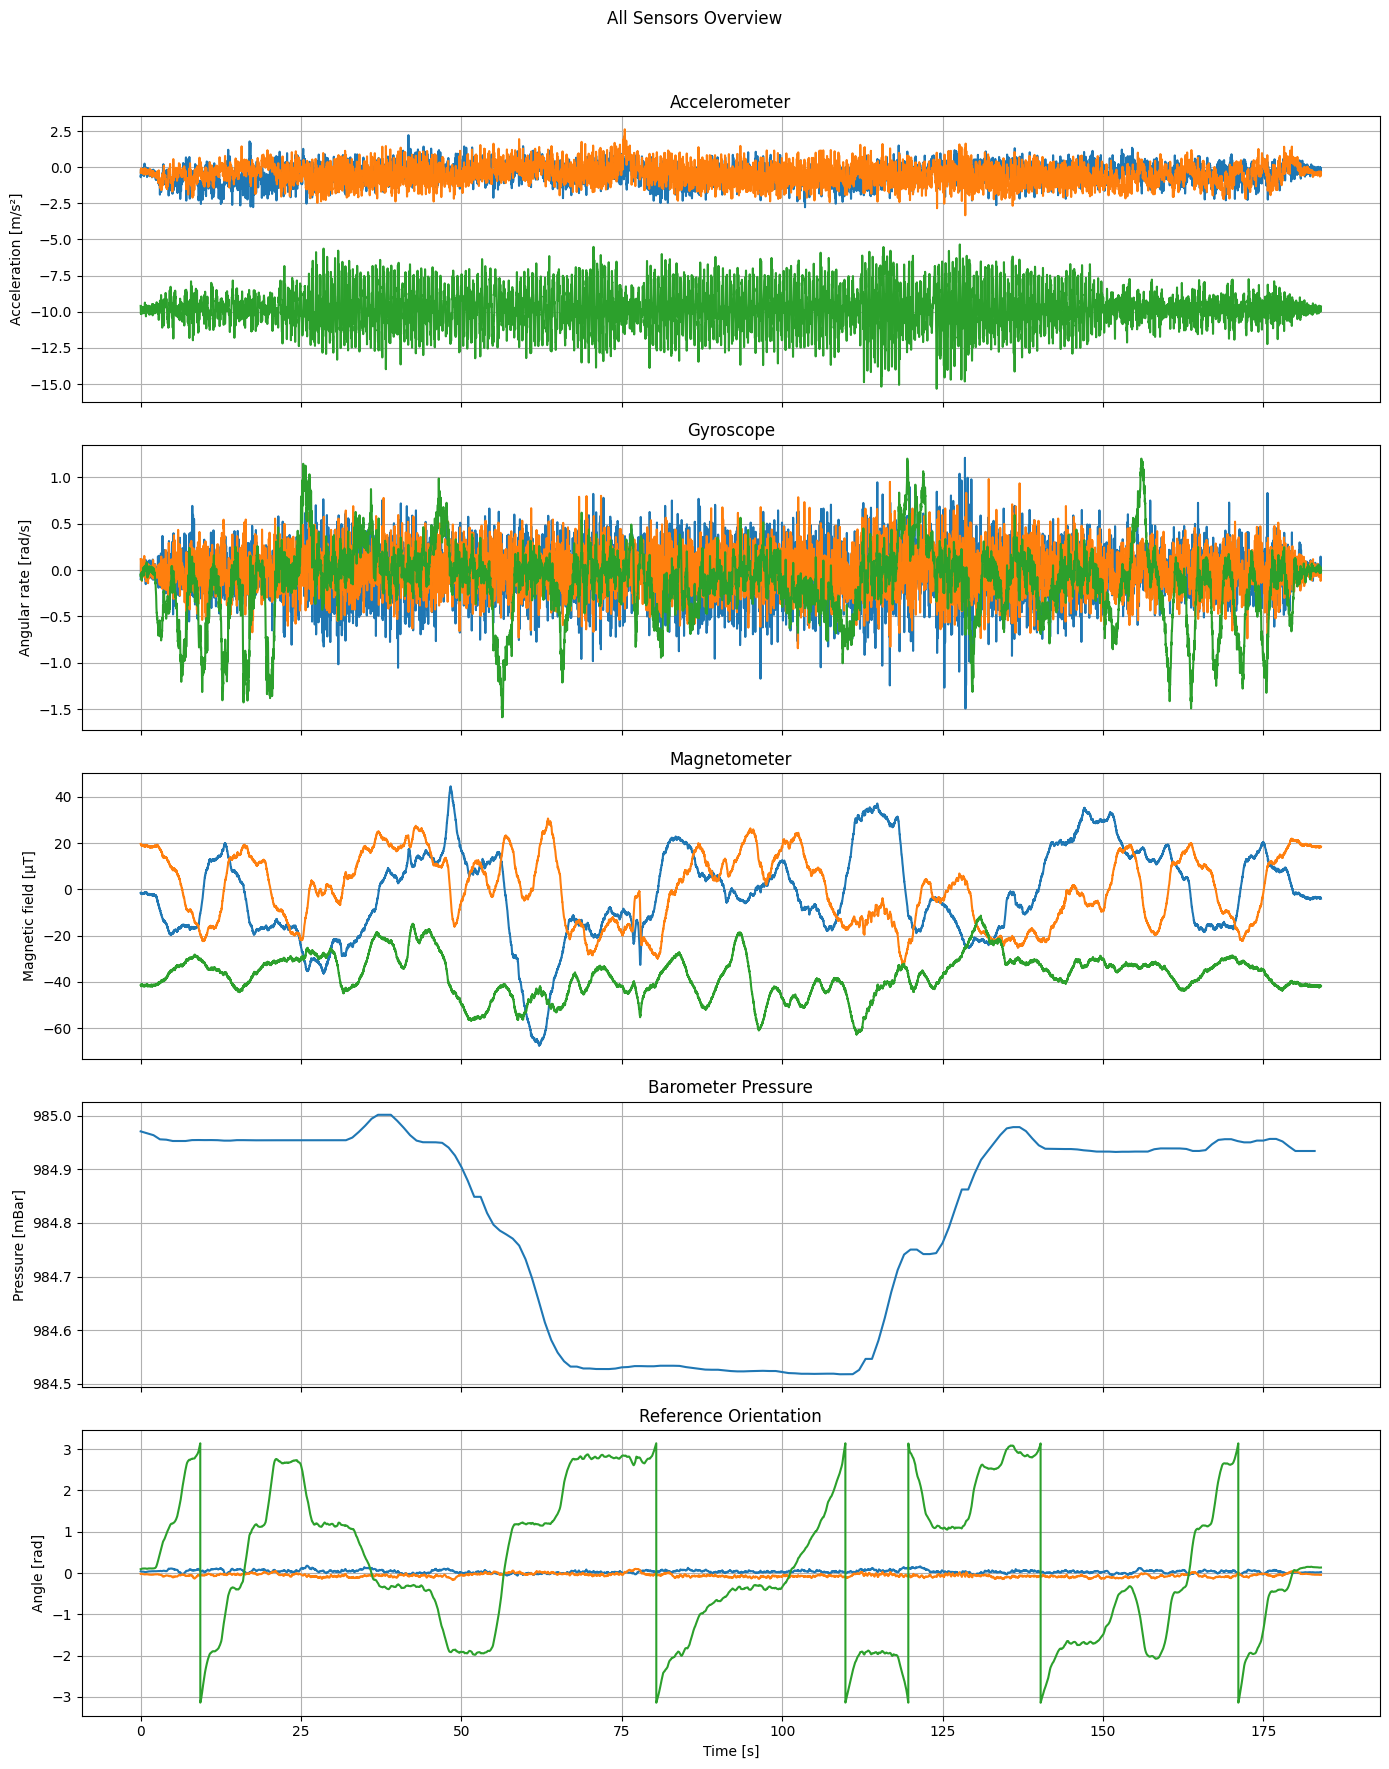

In [476]:
##### Sensor Plots
fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

# Accelerometer
axs[0].plot(acc_data["t"], acc_data[["acc_x","acc_y","acc_z"]])
axs[0].set_title("Accelerometer")
axs[0].set_ylabel("Acceleration [m/s²]")
axs[0].grid(True)

# Gyroscope
axs[1].plot(gyro_data["t"], gyro_data[["gyro_x","gyro_y","gyro_z"]])
axs[1].set_title("Gyroscope")
axs[1].set_ylabel("Angular rate [rad/s]")
axs[1].grid(True)

# Magnetometer
axs[2].plot(mag_data["t"], mag_data[["mag_x","mag_y","mag_z"]])
axs[2].set_title("Magnetometer")
axs[2].set_ylabel("Magnetic field [µT]")
axs[2].grid(True)

# Barometer
axs[3].plot(baro_data["t"], baro_data["pressure"])
axs[3].set_title("Barometer Pressure")
axs[3].set_ylabel("Pressure [mBar]")
axs[3].grid(True)

# Reference Orientation
axs[4].plot(ref_data["t"], ref_data[["roll","pitch","yaw"]])
axs[4].set_title("Reference Orientation")
axs[4].set_ylabel("Angle [rad]")
axs[4].set_xlabel("Time [s]")
axs[4].grid(True)

plt.suptitle("All Sensors Overview")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

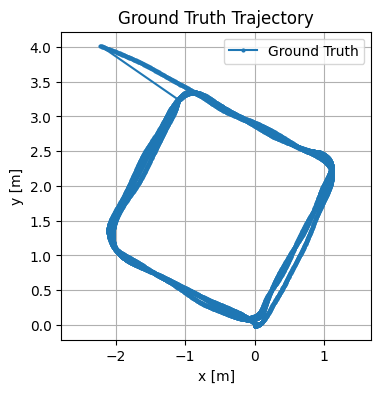

In [477]:
# Plot Trajectory / position
# Ground Truth -> XY trajectory for comparison with dead reckoning

plt.figure(figsize=(4,4))
plt.plot(grtr_data["x"], grtr_data["y"], marker='o', markersize=2, label="Ground Truth")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Ground Truth Trajectory")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

##### Data Preprocessing

In [478]:
# Preprocessing: Acceleration
# Gesamte Beschleunigung
acc_data["acc_norm"] = np.sqrt(acc_data["acc_x"]**2 + acc_data["acc_y"]**2 + acc_data["acc_z"]**2)

# Bandpass Filter für Schritte (0.7 - 3 Hz)
lowcut, highcut, order = 0.7, 3.0, 2
b, a = butter(order, [lowcut/(0.5*fs), highcut/(0.5*fs)], btype='band')
acc_data["acc_filt"] = filtfilt(b, a, acc_data["acc_norm"])

# Glättung (Savitzky–Golay)
acc_data["acc_smooth"] = savgol_filter(acc_data["acc_filt"], window_length=int(0.5*fs)|1, polyorder=2)


In [479]:
# Total acceleration
#acc_data["acc_norm"] = np.sqrt(
#    acc_data["acc_x"]**2 + 
 #   acc_data["acc_y"]**2 + 
  #  acc_data["acc_z"]**2)

#acc_data.head()

In [480]:
# Bandpass filter for steps
#lowcut, highcut, order = 0.7, 3.0, 2
#b, a = butter(order, [lowcut/(0.5*fs), highcut/(0.5*fs)], btype='band')
#acc_data["acc_filt"] = filtfilt(b, a, acc_data["acc_norm"])

# Smooth signal
#acc_data["acc_smooth"] = savgol_filter(acc_data["acc_filt"], window_length=int(0.5*fs)|1, polyorder=2)


In [481]:
# Lowpass für Weinberg (Amplitude erhalten)
#cutoff_lp = 3.0  # Hz
#order_lp = 2

#b_lp, a_lp = butter(
#    order_lp,
#    cutoff_lp / (0.5 * fs),
#    btype="low"
#)

#acc_data["acc_lp"] = filtfilt(b_lp, a_lp, acc_data["acc_norm"])


In [482]:
# Low-pass filter (Step frequencies)
#cutoff = 3.0  # Hz (Schritte liegen darunter)
#order = 2     # reicht völlig

#b, a = butter(order, cutoff / (0.5 * fs), btype="low")
#acc_data["acc_filt"] = filtfilt(b, a, acc_data["acc_norm"])


# Bandpass-Filter für Schritte (typisch Weinberg)
#lowcut = 0.7
#highcut = 3.0
#order = 2

#b, a = butter(
 #   order,
  #  [lowcut / (0.5 * fs), highcut / (0.5 * fs)],
   # btype="band"
#)
#acc_data["acc_filt"] = filtfilt(b, a, acc_data["acc_norm"])


In [483]:
# Smoothing with Savitzky–Golay
#acc_data["acc_smooth"] = savgol_filter(
#    acc_data["acc_filt"],
 #   window_length=int(0.5 * fs) | 1,
  #  polyorder=2
#)



##### Step Detection: Peak Detection

Detected steps: 237
Mean step interval: 0.73 s
Step frequency: 1.36 Hz


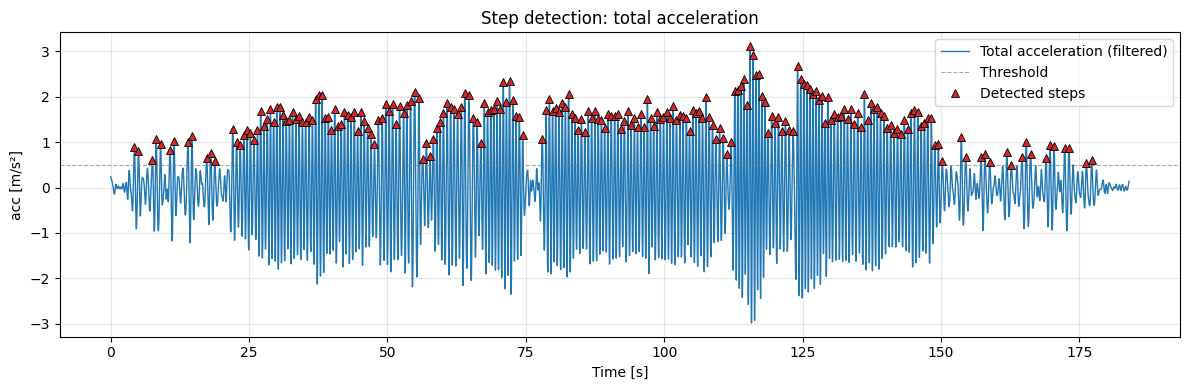

In [484]:
threshold = np.mean(acc_data["acc_smooth"]) + 0.5
peaks, _ = find_peaks(acc_data["acc_smooth"], height=threshold, distance=0.4*fs)

step_times = acc_data["t"].iloc[peaks].values
step_intervals = np.diff(step_times)

print(f"Detected steps: {len(peaks)}")
print(f"Mean step interval: {np.mean(step_intervals):.2f} s")
print(f"Step frequency: {1/np.mean(step_intervals):.2f} Hz")


# Visualisation - Step Detection
plt.figure(figsize=(12,4))

plt.plot(acc_data["t"], 
         acc_data["acc_smooth"], 
         label="Total acceleration (filtered)", 
         linewidth=1.0)

plt.axhline(threshold, 
            color="gray", 
            linestyle="--", 
            linewidth=0.8, alpha=0.7, 
            label="Threshold")

plt.plot(acc_data["t"].iloc[peaks], 
         acc_data["acc_smooth"].iloc[peaks], 
         linestyle="None",
         marker="^", markersize=6, markerfacecolor="#d62728", 
         markeredgecolor="black", markeredgewidth=0.6, 
         label="Detected steps")

plt.xlabel("Time [s]")
plt.ylabel("acc [m/s²]")
plt.title("Step detection: total acceleration")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [485]:
# Step timing sanity check
#step_times = acc_data.index[peaks].values
#step_intervals = np.diff(step_times)

#print(f"Mean step interval: {np.mean(step_intervals):.2f} s")
#print(f"Step frequency: {1/np.mean(step_intervals):.2f} Hz")


##### Step length estimation

Calibrated k = 0.530
Mean step length: 0.80 m
Min / Max step length: 0.65 m / 0.93 m


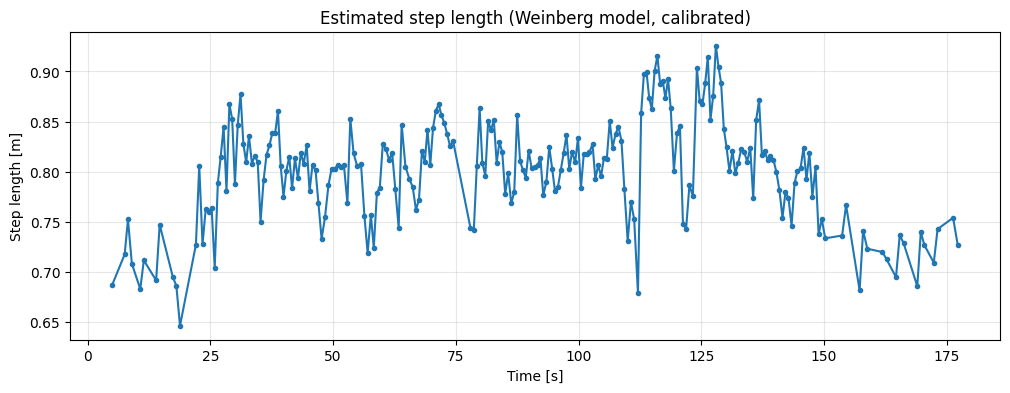

In [486]:
# ----------------------------
# Step Length Estimation (Weinberg Model)
# ----------------------------

# Remove gravity on z-axis
acc_data["acc_z_gf"] = acc_data["acc_z"] - 9.81

weinberg_terms = []

# Compute Weinberg terms for each step
for i in range(1, len(peaks)):
    idx_prev, idx_curr = peaks[i-1], peaks[i]
    segment = acc_data["acc_z_gf"].iloc[idx_prev:idx_curr] - acc_data["acc_z_gf"].iloc[idx_prev:idx_curr].mean()
    a_max, a_min = segment.max(), segment.min()
    weinberg_terms.append((a_max - a_min)**0.25)

weinberg_terms = np.array(weinberg_terms)

# ----------------------------
# Calibrate k to typical step length (~0.8 m)
# ----------------------------
typical_step_length = 0.8  # meters (0.3 m on stairs if needed)
k = typical_step_length / np.mean(weinberg_terms)
step_lengths = k * weinberg_terms

print(f"Calibrated k = {k:.3f}")
print(f"Mean step length: {np.mean(step_lengths):.2f} m")
print(f"Min / Max step length: {step_lengths.min():.2f} m / {step_lengths.max():.2f} m")

# ----------------------------
# Step Length Visualization
# ----------------------------
plt.figure(figsize=(12,4))
plt.plot(step_times[1:], step_lengths, ".-")
plt.xlabel("Time [s]")
plt.ylabel("Step length [m]")
plt.title("Estimated step length (Weinberg model, calibrated)")
plt.grid(alpha=0.3)
plt.show()


##### Improvement using Barometer height

In [ ]:
# sjadf
